# Word to vec Embedding Models

--------

In [3]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt
import nltk
from xgboost import XGBClassifier
from collections import Counter
import time
import tensorflow as tf


# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
import seaborn as sns
from sklearn.manifold import TSNE
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Text analysis helper libraries
from gensim.summarization import summarize
from gensim.summarization import keywords


# Text analysis helper libraries for word frequency etc..
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation


# Word cloud visualization libraries
from scipy.misc import imresize
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter


# Word2Vec related libraries
from gensim.models import KeyedVectors
# Dimensionaly reduction libraries
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder



### Get the data

In [25]:
train = pd.read_csv('data.csv')

### Visualizing Word to Vec Imbedding

In [ ]:
import w2vec_helper

In [44]:
text = train['Text']
all_txt = ''
for k in range(len(text)):
           txt = text.iloc[k]
           all_txt = all_txt+txt
words = preprocess(all_txt)
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))
print(words[:30])

['the', 'minimum', 'description', 'length', 'principle', 'for', 'sequence', 'in', 'a', 'proper', 'learning', 'setup', 'is', 'studied', 'if', 'the', 'underlying', 'model', 'class', 'is', 'discrete', '<COMMA>', 'then', 'the', 'total', 'expected', 'square', 'loss', 'is', 'a']


In [46]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [47]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

### Prepare batches and targets

In [48]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [49]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

#### Embedding

Tensorflow provides a convenient function ***tf.nn.embedding_lookup*** that does this lookup for us. You pass in the ```embedding matrix``` and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use ```tf.nn.embedding_lookup``` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using ```tf.random_uniform```.

In [50]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

In [51]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

#### Negative Sampling

In [52]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

#### Validation

In [53]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm

In [54]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: checkpoints: File exists


#### Train embedding

In [55]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

In [56]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

#### Visualization

In [57]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

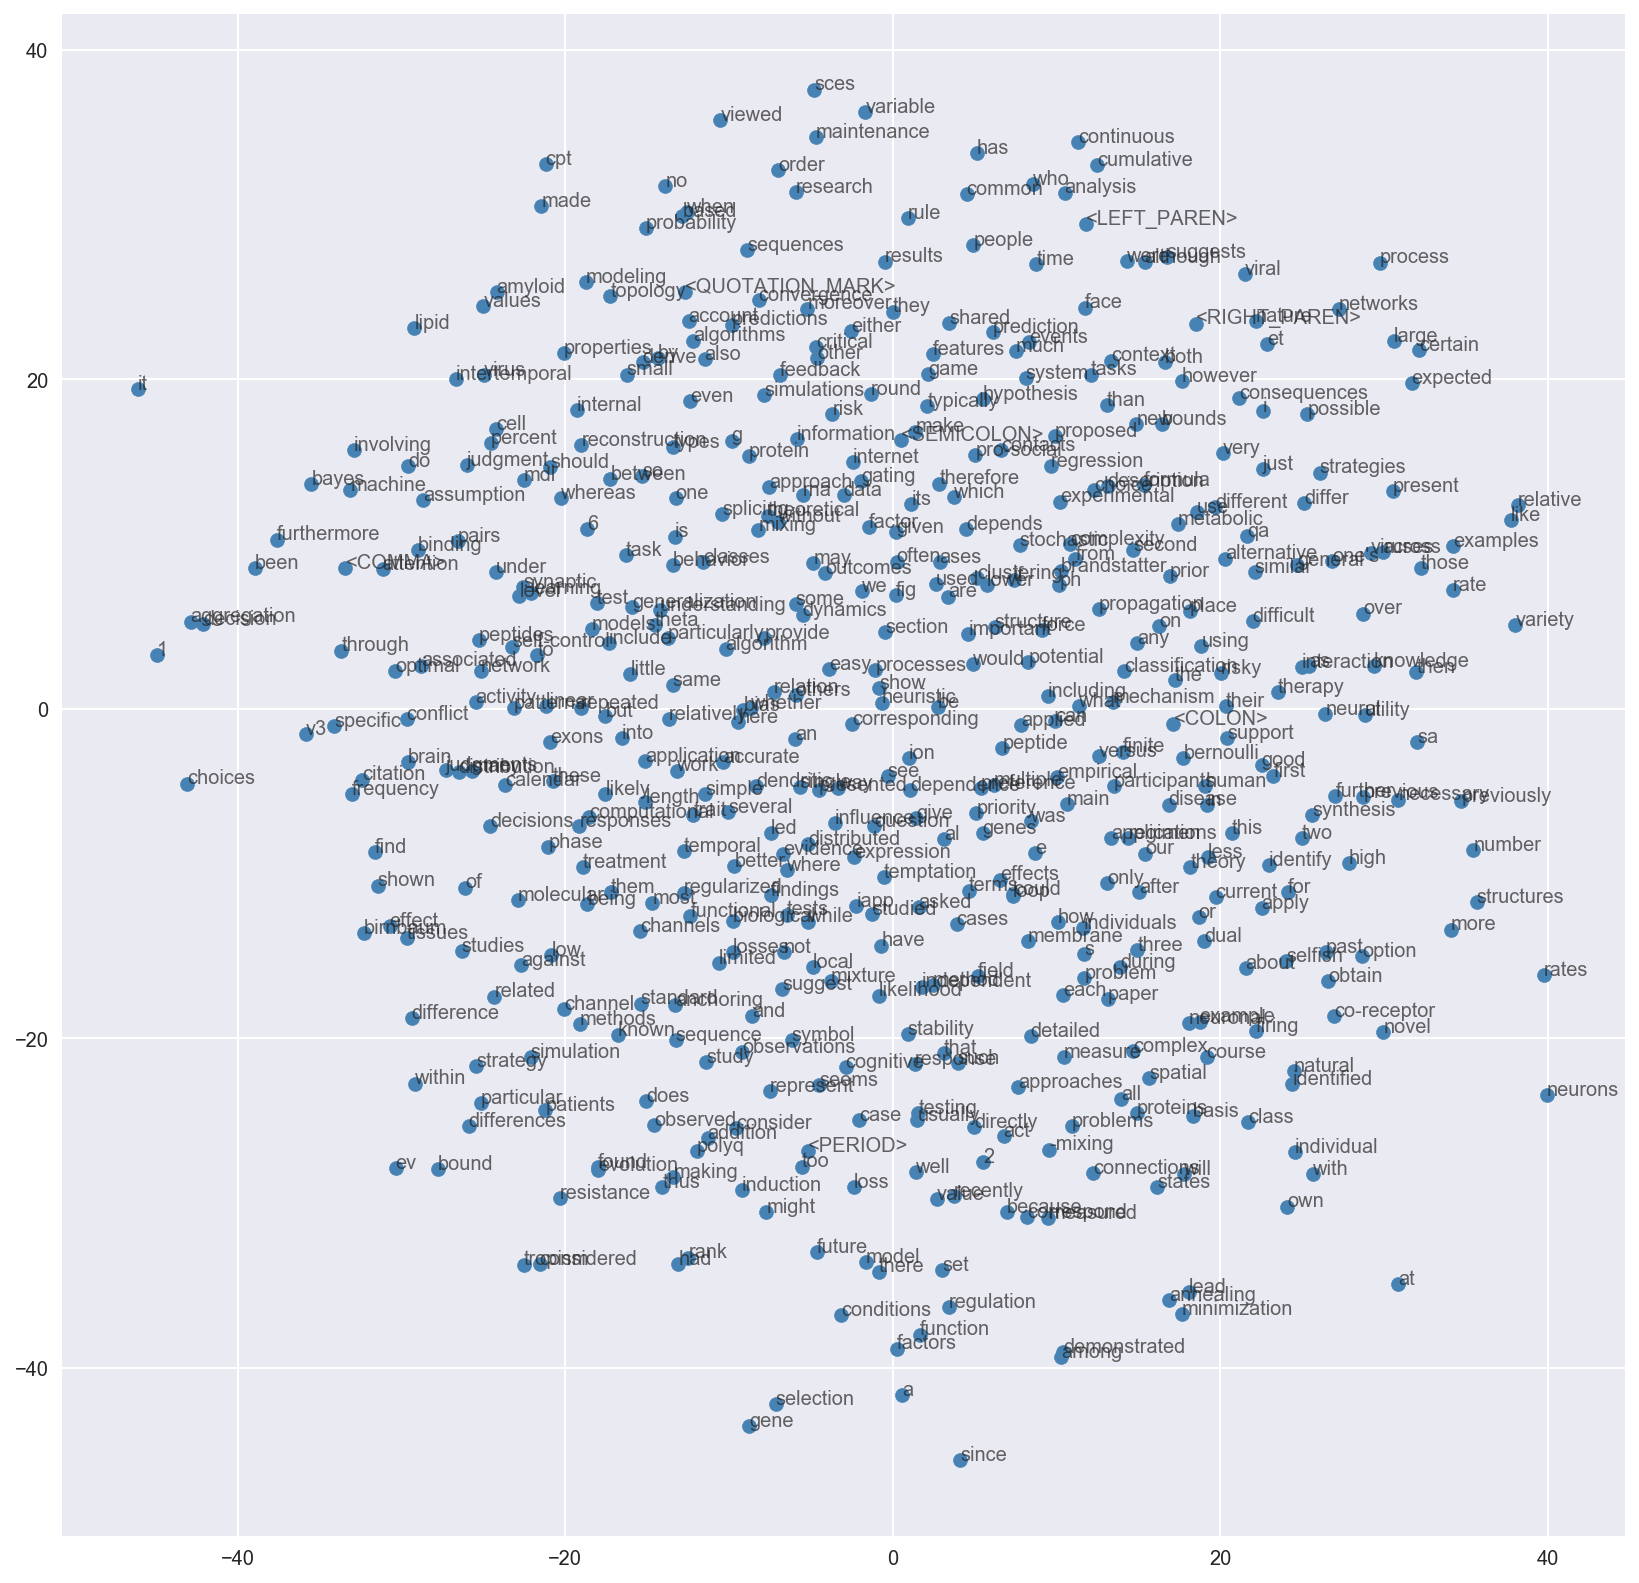

In [58]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [ ]:
print(embed_mat)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(embed_mat, cmap='hot', interpolation='nearest')
plt.show()

--------

### 6.2 RNN with LSTM and word2vec embedding

------

In [59]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [60]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train['Text'].values)

In [61]:
# Pad the data 
X = tokenizer.texts_to_sequences(train['Text'].values)
X = pad_sequences(X, maxlen=2000)

In [62]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()

model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))

model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))

model.add(Dense(5,activation='softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['categorical_crossentropy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 985       
Total params: 511,785
Trainable params: 511,785
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
Y = pd.get_dummies(train['Label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify=Y)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2493, 2000) (2493, 5)
(624, 2000) (624, 5)


In [67]:
batch_size = 64
history = model.fit(X_train,
          Y_train, 
          epochs=8, 
          batch_size=batch_size,
          validation_split=0.2,
          callbacks=[ckpt_callback])

Train on 1994 samples, validate on 499 samples
Epoch 1/8
1994/1994 [==============================] - 397s - loss: 0.2559 - categorical_crossentropy: 0.2559 - val_loss: 0.5207 - val_categorical_crossentropy: 0.5207
Epoch 2/8
1994/1994 [==============================] - 391s - loss: 0.2103 - categorical_crossentropy: 0.2103 - val_loss: 0.5107 - val_categorical_crossentropy: 0.5107
Epoch 3/8
1994/1994 [==============================] - 397s - loss: 0.1989 - categorical_crossentropy: 0.1989 - val_loss: 0.5112 - val_categorical_crossentropy: 0.5112
Epoch 4/8
1994/1994 [==============================] - 603s - loss: 0.1790 - categorical_crossentropy: 0.1790 - val_loss: 0.5087 - val_categorical_crossentropy: 0.5087
Epoch 5/8
1994/1994 [==============================] - 418s - loss: 0.1615 - categorical_crossentropy: 0.1615 - val_loss: 0.5374 - val_categorical_crossentropy: 0.5374
Epoch 6/8
1994/1994 [==============================] - 371s - loss: 0.1590 - categorical_crossentropy: 0.1590 - v

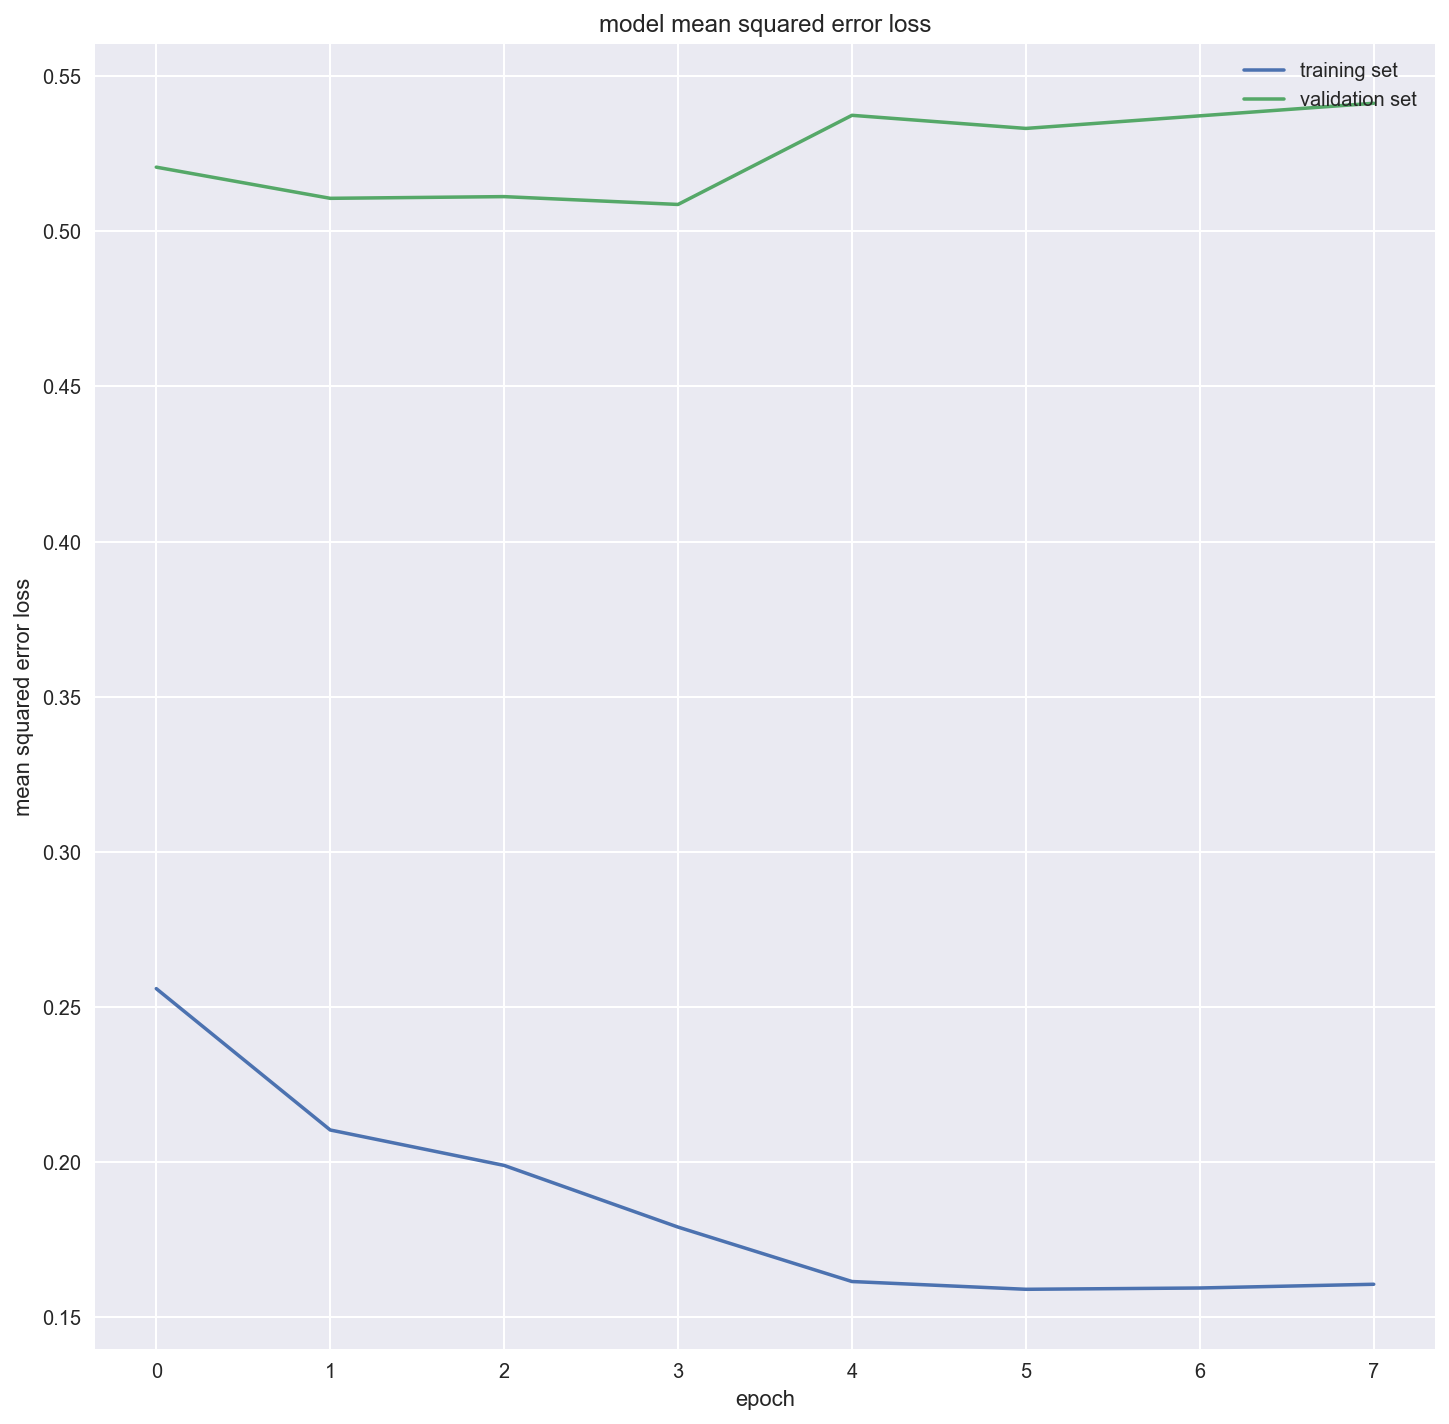

In [68]:
plt.figure(figsize=(12,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

Log loss: 0.5760836581541344
Accuracy: 0.8253205128205128


/Users/dibakarsigdel/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


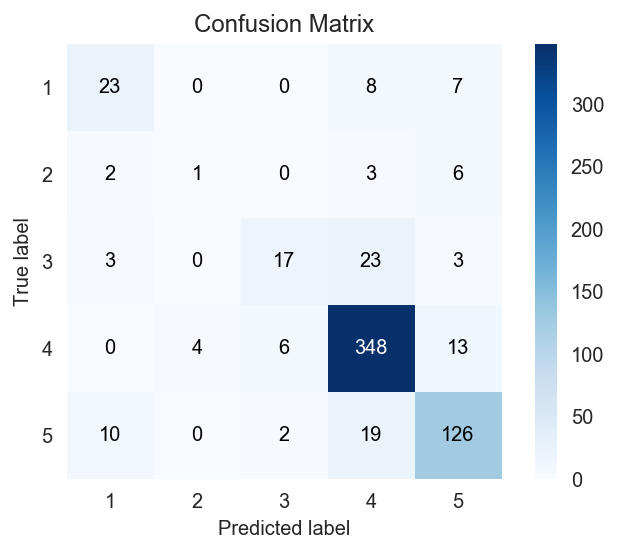

In [69]:
model = load_model('keras_model')
probas = model.predict(X_test)
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)

-------